In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from data_loader import data_label_split
from data_loader import generate_data_set

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [2]:
def z_score(splits, X, y, model, control = 0, treatment = 1, verbose = 0):
    skf = StratifiedKFold(n_splits = splits)
    z_score_control = []
    z_score_treatment = []
    mean_accuracy = []
    if type(X) == np.ndarray:
        for i, (train_index, test_index) in enumerate(skf.split(X, y)):
            if verbose != 0:
                print("Fold %d" % i, "TRAIN:", train_index , "TEST:", test_index)
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            lgs = model.fit(X_train, y_train)
            z_score_control.append(lgs.predict_proba(X_test[y_test==control])[:,0].mean())
            z_score_treatment.append(lgs.predict_proba(X_test[y_test==treatment])[:,1].mean())
            mean_accuracy.append(lgs.score(X_test, y_test))
#         print(y_test, lgs.predict_proba(X_test[y_test==0])[:,0], lgs.predict_proba(X_test[y_test==1])[:,1])
    elif type(X) == pd.core.frame.DataFrame:
         for i, (train_index, test_index) in enumerate(skf.split(X, y)):
            if verbose != 0:
                print("Fold %d" % i, "TRAIN:", train_index , "TEST:", test_index)
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            lgs = model.fit(X_train, y_train)
            z_score_control.append(lgs.predict_proba(X_test[y_test==control])[:,0].mean())
            z_score_treatment.append(lgs.predict_proba(X_test[y_test==treatment])[:,1].mean())
            mean_accuracy.append(lgs.score(X_test, y_test))
    return mean_accuracy, z_score_control, z_score_treatment

In [101]:
def mini_noise_signal_cv(size, data, treatment, control, model, cv, verbose):
    mean_mean_accuracy=[]
    std_mean_accuracy=[]
    mean_z_score_control=[]
    std_z_score_control=[]
    mean_z_score_treatment=[]
    std_z_score_treatment=[]
    for i in range(5,96,5):
        mini_batch = generate_data_set(size, i/100, data, treatment, control)
        X, y = data_label_split(mini_batch)
#         y = y["compound"]
#         lb = LabelEncoder()
#         y_true = lb.fit_transform(y['compound']) # 0 for DMSO, 1 for taxol
        mean_accuracy, z_score_control, z_score_treatment = z_score(cv, X, y, model,"DMSO", "taxol", verbose = verbose)
        mean_mean_accuracy.append(np.mean(mean_accuracy))
        std_mean_accuracy.append(np.std(mean_accuracy))
        mean_z_score_control.append(np.mean(z_score_control))
        std_z_score_control.append(np.std(z_score_control))
        mean_z_score_treatment.append(np.mean(z_score_treatment))
        std_z_score_treatment.append(np.std(z_score_treatment))
    return mean_mean_accuracy, std_mean_accuracy, mean_z_score_control, std_z_score_control, mean_z_score_treatment, std_z_score_treatment

In [ ]:
drop_NA_data=pd.read_csv("moa_data_drop_NA.csv", index_col=0)

# Logistic Regression

In [53]:
model =  LogisticRegression(max_iter = 10000, solver = "saga", n_jobs = -1)

In [102]:
mean_mean_accuracy, std_mean_accuracy, mean_z_score_control, std_z_score_control, mean_z_score_treatment, std_z_score_treatment = mini_noise_signal_cv(1000, 
drop_NA_data, "taxol", "DMSO", model, 10,1)

Fold 0 TRAIN: [ 98  99 100 101 102 103 104 105 107 108 109 110 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207
 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225
 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243
 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261
 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279
 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297
 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315
 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333
 334 335 336 337 338 339 340 341 342 

In [115]:
mean_z_score_control = np.array(mean_z_score_control)
std_z_score_control = np.array(std_z_score_control)
mean_z_score_treatment = np.array(mean_z_score_treatment)
std_z_score_treatment = np.array(std_z_score_treatment)

Text(0.5, 1.0, 'DMSO prediction score with change of %taxol')

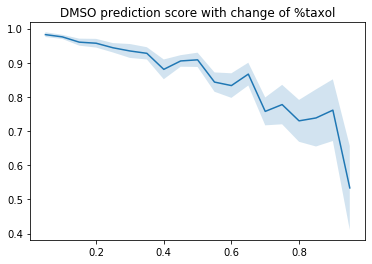

In [113]:
plt.plot([i/100 for i in range(5,96,5)], mean_z_score_control, '-')
plt.fill_between([i/100 for i in range(5,96,5)], 
                 (mean_z_score_control)-std_z_score_control, mean_z_score_control+std_z_score_control, alpha=0.2)
plt.title("DMSO prediction score with change of %taxol")

Text(0.5, 1.0, 'taxol prediction score v.s. change of %taxol\n minibatch with size 500, Logistic Regression')

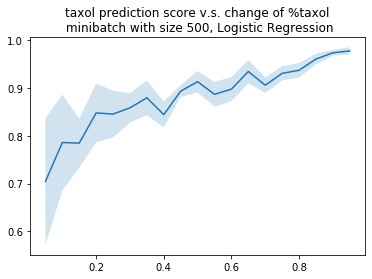

In [121]:
plt.plot([i/100 for i in range(5,96,5)], mean_z_score_treatment, '-')
plt.fill_between([i/100 for i in range(5,96,5)], 
                 (mean_z_score_treatment)-std_z_score_treatment, mean_z_score_treatment + std_z_score_treatment, alpha=0.2)
plt.title("taxol prediction score v.s. change of %taxol\n minibatch with size 500, Logistic Regression")
# plt.subtitle("taxol prediction score with change of %taxol")

# RF

In [122]:
RF_model =  RandomForestClassifier(min_samples_split=50, random_state=0)

In [ ]:
mean_mean_accuracy1, std_mean_accuracy1, mean_z_score_control1, std_z_score_control1, mean_z_score_treatment1, std_z_score_treatment1 = mini_noise_signal_cv(500,
drop_NA_data, "taxol", "DMSO", RF_model, 10, 1) 

Fold 0 TRAIN: [ 13  30  51  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85
  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157
 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175
 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193
 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211
 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229
 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247
 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265
 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283
 284 285 286 287 288 289 290 291 292 

In [75]:
def generate_data_set(size, perc, data, treatment, control):
    treatment_data = data[data["compound"] == treatment]
    control_data = data[data["compound"] == control]
    num_treat = int(size * perc)
    return treatment_data.sample(num_treat).append(control_data.sample(size - num_treat)).sample(frac = 1).reset_index(drop=True)

In [313]:
data = generate_data_set(20000, 0.05, drop_NA_data, "taxol", "DMSO")

In [74]:
def data_label_split(data):
    meta_list = []
    for i in data.columns:
        if "Meta" in i:
            meta_list.append(i)
    label = data["compound"]
    train = data.drop(meta_list + ["compound", "concentration", "moa", "row ID", "Iteration (#2)", "COND"], axis = 1)
    
    return train, label

In [303]:
skf = StratifiedKFold(n_splits = 5)
z_score_control = []
z_score_treatment = []
for i, (train_index, test_index) in enumerate(skf.split(train_data, labels["compound"])):
    print(i, "TRAIN:", train_index , "TEST:", test_index)
#     X_train, X_test = train_data.iloc[train_index], train_data.iloc[test_index]
#     y_train, y_test = labels["compound"].iloc[train_index], labels["compound"].iloc[test_index]
#     lgs = LogisticRegression(max_iter = 1000, solver = "saga").fit(X_train, y_train)
#     z_score_control.append(lgs.predict_proba(X_test[y_test=="DMSO"])[:,0].mean())
#     z_score_treatment.append(lgs.predict_proba(X_test[y_test=="taxol"])[:,1].mean())
#     print(y_test, lgs.predict_proba(X_test[y_test=='DMSO'])[:,0], lgs.predict_proba(X_test[y_test=="taxol"])[:,1])
# print(z_score_control, z_score_treatment)

0 TRAIN: [ 40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111
 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147
 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165
 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183
 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199] TEST: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
1 TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  78  81  82  83  84  85  86  87  88  89 

In [51]:
mean_accuracy, z_score_control, z_score_treatment = z_score(5, train_data, labels["compound"], 
        LogisticRegression(max_iter = 1000, solver = "saga", n_jobs = -1), "DMSO", "taxol")

ValueError: could not convert string to float: 'PC'

In [316]:
mean_accuracy, z_score_control, z_score_treatment = z_score(5, train_data, labels["compound"], 
        LogisticRegression(max_iter = 1000, solver = "saga", n_jobs = -1), "DMSO", "taxol")

([0.95, 0.925, 0.95, 0.95, 0.9230769230769231],
 [0.4856366274544099,
  0.4164521924682437,
  0.5817536906724418,
  0.5290726077483126,
  0.2842644305913188],
 [0.9670663085581831,
  0.9628653840989168,
  0.9335449915101672,
  0.9669022766447544,
  0.9410320792688063])

In [42]:
lgs = LogisticRegression(max_iter = 1000, solver = "saga")
cv_results = cross_validate(lgs, train_data, labels["compound"], 
                            cv=10, scoring=("accuracy"), verbose = 1, n_jobs = 20)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   4 out of  10 | elapsed:  2.7min remaining:  4.0min
[Parallel(n_jobs=20)]: Done  10 out of  10 | elapsed:  2.7min finished


In [27]:
scores

array([0.9685, 0.969 , 0.973 , 0.9685, 0.969 , 0.9735, 0.97  , 0.9705,
       0.9655, 0.968 ])

In [30]:
np.mean(scores)

0.9695500000000001

In [43]:
cv_results

{'fit_time': array([159.99139667, 158.12105441, 159.26302505, 160.55608273,
        160.49164653, 155.83465528, 156.26937437, 157.74180651,
        160.64376068, 158.88100719]),
 'score_time': array([0.06685877, 0.0707736 , 0.07745552, 0.06985831, 0.04581904,
        0.07385373, 0.07400751, 0.07086849, 0.03564024, 0.05111647]),
 'test_score': array([0.9685, 0.969 , 0.973 , 0.9685, 0.969 , 0.9735, 0.97  , 0.9705,
        0.9655, 0.968 ])}

In [87]:
def mini_noise_signal(size, data, treatment, control, model):
    p_acc=[]
    n_acc=[]
    for i in range(5,96,5):
        mini_batch = generate_data_set(size, i/100, data, "taxol", "DMSO")
        X, y = data_label_split(mini_batch)
        y=y['compound']
        model.fit(X, y)
        y_pred = model.predict(X)
        cm = confusion_matrix(y,y_pred)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        n_acc.append(cm.diagonal()[0])
        p_acc.append(cm.diagonal()[1])
    return p_acc, n_acc

In [88]:
clf = RandomForestClassifier(min_samples_split=50, random_state=0)

In [89]:
p_, n_ = mini_noise_signal(1000, drop_NA_data, "taxol", "DMSO", clf)

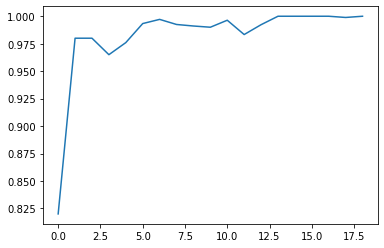

In [93]:
plt.plot(n_)

In [74]:
p_acc=[]
n_acc=[]
for i in range(5,96,5):
    mini_batch = generate_data_set(1000, i/100, drop_NA_data, "taxol", "DMSO")
    X, y = data_label_split(mini_batch)
    y=y['compound']
    
    clf = LogisticRegression(max_iter = 10000, solver = "saga")
    clf.fit(X, y)
    y_pred = clf.predict(X)
    cm = confusion_matrix(y,y_pred )
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    n_acc.append(cm.diagonal()[0])
    p_acc.append(cm.diagonal()[1])

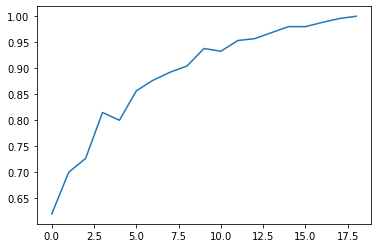

In [78]:
plt.plot(n_acc)

In [63]:

mini_batch = generate_data_set(100, 0.5, drop_NA_data, "taxol", "DMSO")
X, y = data_label_split(mini_batch)
lb = LabelEncoder()
# y = lb.fit_transform(y['compound'])
y=y['compound']

In [64]:
clf = LogisticRegression(max_iter = 10000, solver = "saga")
clf.fit(X, y)
y_pred = clf.predict(X)

In [65]:
cm = confusion_matrix(y,y_pred )

In [66]:
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [73]:
cm.diagonal()[0]

0.88

In [68]:
confusion_matrix(y,y_pred )

array([[44,  6],
       [ 2, 48]])

Text(0.5, 0, 'percent of taxol')

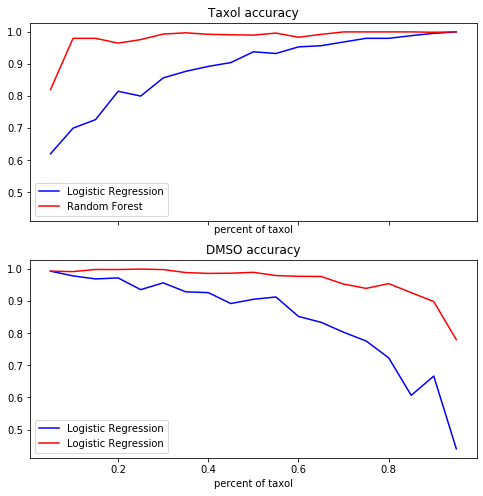

In [112]:
fig, ax = plt.subplots(2, sharex=True, sharey=True,figsize=(8, 8))
l1 = ax[0].plot([i/100 for i in range(5,96,5)], n_acc, color = 'b', label = "Logistic Regression")
l2 = ax[0].plot([i/100 for i in range(5,96,5)], n_, color = 'r', label = "Random Forest")
ax[0].legend()
ax[0].title.set_text("Taxol accuracy")
ax[0].set_xlabel('percent of taxol')
l3 = ax[1].plot([i/100 for i in range(5,96,5)], p_acc, color = 'b',label = "Logistic Regression")
l4 = ax[1].plot([i/100 for i in range(5,96,5)], p_, color = 'r',label = "Logistic Regression")
ax[1].legend()
ax[1].title.set_text("DMSO accuracy")
ax[1].set_xlabel('percent of taxol')